In [1]:
#что б тебе какой-нибудь music2vec не написать???

# Кластеризация музыкальной коллекции

В данном проекте мы сделаем кластеризацию музыкальной коллекции, состоящей примерно из 800 треков различной жанровой направленности. 
Изначальным форматом треков был mp3. 
По результатам кластеризации мы отрисуем график взаимного расположения комфпозиций на двумерной плоскости.

Наложим некоторые ограничения на задачу, которые позволят нам построить достаточно внятный и логичный базовый алгоритм этого проекта. 
В первую очередь оговорим, что при решении задачи мы не будем использовать различные теги, который зачастую содержатся в музыкальных файлах и несут некоторую (не всегда достоверную и объективную) информацию о жанре, исполнителе, годе выпуска и пр. Сходство или различие треков вычисляется исключительно на основании статистических показателей звучания. 

Независимость от внешней информации позволит сделать данный алгоритм универсальным. Его можно будет использовать для кластеризации любой музыкальной коллекции.

Напишем примерную схему решения задачи:

1. Конвертируем mp3 в wav с определенными показателями
2. Извлечем статистические признаки
3. Найдем оптимальное подмножество признаков, которые наилучшим образом будут влиять на результат кластеризации
4. Выполним уменьшение размерности до 2 для распределения точек-треков на плоскости
5. Возвращаемся в исходное пространство признаков и выполняем кластеризацию при помощи k-means
6. Раскрашиваем кластеры

# Конвертация mp3-файлов

Вначале задачи конвертируем нашу коллекцию. Это позволит нам использовать стандартный модуль Питона для работы с данными.
При конвертации установим частоту дискретизации 8кГц и стерео-канал преобразуем в моно, чтобы универсализовать нашу работу.

Конвертацию коллекции будем делать при помощи программы foobar2000, которая позволяет сделать это автоматически для всей коллекции за достаточно короткое время и без дополнительного ненужного програмного кода.


# Формирование списка признаков 

Wav-файл - это набор данных, состоящий из базовых данных о треке и данных самого трека.

In [1]:
import subprocess
import wave
import struct
import numpy
import csv
import sys
import os

In [2]:
import pandas as pd

In [5]:
import scipy.io.wavfile

In [6]:
import sklearn

Выделим первую группу признаков. Ей будут статистические моменты сигнала: среднее, среднеквадратичное отклонение, к. ассиметрии и к. эксцесса. Эти признаки вычислим на данных исходных амплитуд, а так же на основе амплитуд, которые мы сгладим окнами в 1, 10 и 100 отсчетов. 

Так же стоит вычислить аналогичные признаки на основе амплитуд, сглаженных разностями первого порядка.

In [10]:
def moments(x):

    mean = x.mean()

    std = x.var()**0.5

    skewness = ((x - mean)**3).mean() / std**3

    kurtosis = ((x - mean)**4).mean() / std**4

    return [mean, std, skewness, kurtosis]

Эти признаки достаточно хорошо характеризуют сигнал во времени, но наш набор признаков был бы не полным без частотных свойств сигнала.
Они вычисляются на основе преобразования Фурье.

In [11]:
def fftfeatures(wavdata):

    f = numpy.fft.fft(wavdata)

    f = f[2:int(f.size / 2 + 1)]

    f = abs(f)

    total_power = f.sum()

    f = numpy.array_split(f, 10)

    return [e.sum() / total_power for e in f]

In [12]:
def features(x):

    x = numpy.array(x)

    f = []



    xs = x

    diff = xs[1:] - xs[:-1]

    f.extend(moments(xs))

    f.extend(moments(diff))



    xs = x.reshape(-1, 10).mean(1)

    diff = xs[1:] - xs[:-1]

    f.extend(moments(xs))

    f.extend(moments(diff))



    xs = x.reshape(-1, 100).mean(1)

    diff = xs[1:] - xs[:-1]

    f.extend(moments(xs))

    f.extend(moments(diff))
    
    
    f.extend(fftfeatures(x))


    return f

В итоге мы получаем 34 различных признака для каждого элемента музыкальной коллекции.

In [ ]:
че, какие 8 забыла?
и что у тебя там за ошибки е??

In [13]:
import glob
file = glob.glob("wav/*.wav")
#file = os.listdir("wav") - а вот так получается список всех имен файлов в заданной директории

In [14]:
ratelist = []
datalist = []
featureslist = []
e=0
for i in file:
    try:
        
        rate, data = scipy.io.wavfile.read(i)
        ratelist.append(rate)
        datalist.append(data)
        f = [i[4:-4]]+features(data)
        featureslist.append(f)
    except:
        e+=1
print(e)

48


Видим, что после конвертации появилось некоторое множество битых треков. Так как их число небольшое по сравнению с размерами всей коллекции, посчитаем их множеством меры ноль и выкинем из рассмотрения без зазрений совести.

Преобразуем наш список признаков в датафрейм и дадим названия столбцам.

In [ ]:
data=pd.DataFrame(featureslist)

In [ ]:
data.columns=['filename',
'amp1mean',
'amp1std',
'amp1skew',
'amp1kurt',
'amp1dmean',
'amp1dstd',
'amp1dskew',
'amp1dkurt',
'amp10mean',
'amp10std',
'amp10skew',
'amp10kurt',
'amp10dmean',
'amp10dstd',
'amp10dskew',
'amp10dkurt',
'amp100mean',
'amp100std',
'amp100skew',
'amp100kurt',
'amp100dmean',
'amp100dstd',
'amp100dskew',
'amp100dkurt',
'power1',
'power2',
'power3',
'power4',
'power5',
'power6',
'power7',
'power8',
'power9',
'power10']

In [ ]:
data.head()

Воспользуемся возможностью сохранения дата-фрейма для удобной работы с ноутбуком.

In [ ]:
import pickle
with open('data.pickle', 'wb') as f:
    pickle.dump(data, f)

In [10]:
data=pd.read_csv('data.csv',index_col=0)

In [71]:
data.head()

,amp1mean,amp1std,amp1skew,amp1kurt,amp1dmean,amp1dstd,amp1dskew,amp1dkurt,amp10mean,amp10std,...,power4,power5,power6,power7,power8,power9,power10,cluster,pca_1,pca_2
(Don't Fear) The Reaper,128.038275,28.822781,0.002045,3.591874,124.065325,115.946796,0.060523,1.033997,128.038275,21.848789,...,0.079799,0.070275,0.082755,0.049203,0.042007,0.029108,0.020578,9,-2.159152,-4.922079
(Everything Is) Debatable,127.994448,40.540281,-0.003320,3.355913,125.209328,111.428537,0.041480,1.061234,127.994448,33.896851,...,0.104740,0.097619,0.076408,0.065094,0.046031,0.029017,0.028929,5,-20.897729,1.378350
007.Deep Purple - Soldier Of For Fortune,128.757679,17.743258,0.200819,4.935643,119.260515,122.194366,0.135967,1.026447,128.757679,13.460657,...,0.100976,0.058943,0.045851,0.031956,0.021925,0.013874,0.014579,2,16.117822,-4.598035
01.t'ak 0N ttn (Vocal- MIKA,127.999675,34.011508,-0.004896,3.222756,122.829056,115.243293,0.081001,1.039540,127.999675,27.508044,...,0.077852,0.076873,0.064977,0.049532,0.044940,0.027195,0.022075,0,-11.049978,-2.112730
1.Cold Seed,128.096315,25.460047,0.065558,3.269057,122.649322,115.482987,0.082069,1.048565,128.096315,20.117347,...,0.078381,0.094090,0.110219,0.092110,0.061574,0.046179,0.030075,9,2.445560,-5.764199


In [11]:
data.index=numpy.array(data.filename)

In [12]:
data.drop(['filename'],axis=1,inplace=True)

Теперь настало время сформировать подмножество признаков, которые влияют лучшим образом на качество работы алгоритма.

In [13]:
features=data.columns

# Кластеризация

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(data[features])

Используя алгоритм K-means кластеризуем наши треки. Опытным путем было найдено, что оптимальное количество кластеров для визуализации - 10. Но на вкус и задачи пользователя это число может варьироваться.

In [15]:
data['cluster']=kmeans.labels_

# Уменьшение размерности

При помощи алгоритма PCA уменьшим размерность векторов. Метод главных компонент применяется к векторам высших размерностей для проекции их координат в пространства меньших размерностей. В данном случае мы хотим спроецировать наши 34-мерные векоторы на классическую двумерную плоскость

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=2)
pca.fit(data[features])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
data['pca_1']=pca.transform(data[features]).T[0]
data['pca_2']=pca.transform(data[features]).T[1]

# Отрисовка результатов

Теперь займемся удобоваримой и наглядной визуализацией результатов.

Мы задаем цвета для каждого получившегося кластера и отрисовываем точки на плоскости с достаточно большим масштабом.

In [52]:
import matplotlib.pyplot as plt

In [66]:
LABEL_COLOR_MAP = {0 : 'xkcd:sky blue',
                   1 : 'xkcd:cyan',
                   2 : 'xkcd:aqua',
                   3 : 'xkcd:magenta',
                   4 : 'xkcd:tan',
                   5 : 'xkcd:lilac',
                   6 : 'xkcd:electric green',
                   7 : 'xkcd:avocado',
                   8 : 'xkcd:denim',
                   9 : 'xkcd:shocking pink'
                   }
labels=numpy.array([kmeans.labels_])[0]
label_color = [LABEL_COLOR_MAP[l] for l in labels]
plt.scatter(data['pca_1'], data['pca_2'], s=150,c=label_color)

In [67]:
for label, x, y in zip(list(data.index), data['pca_1'], data['pca_2']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(0, 0),
        textcoords='offset points')

In [68]:
plt.rcParams["figure.figsize"]

[12.0, 9.0]

In [69]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

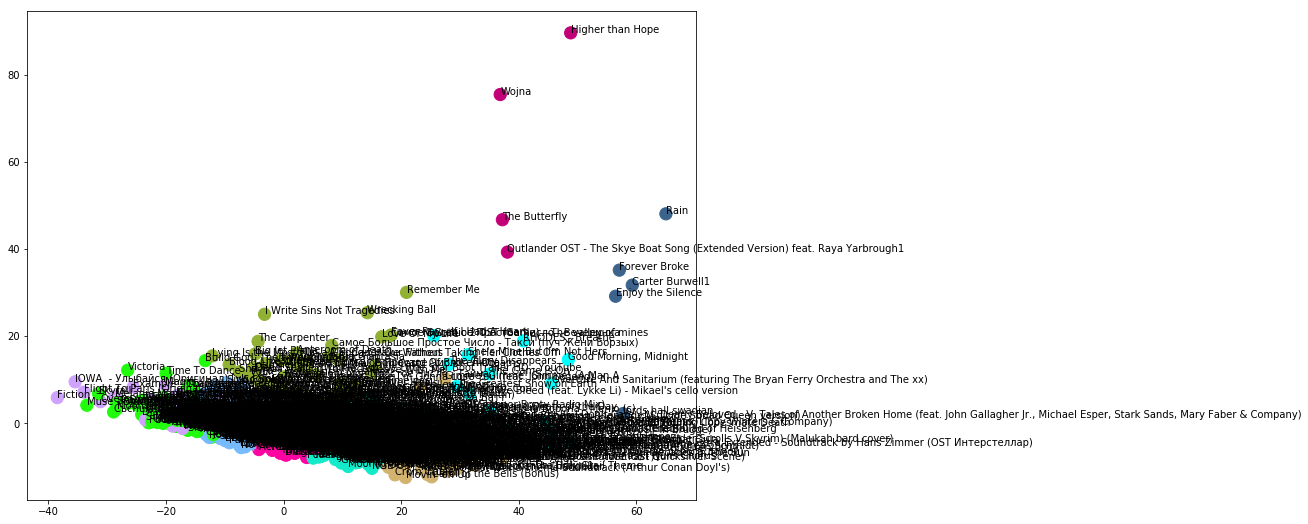

In [70]:
plt.show()

In [ ]:
честно, вот нихуя

In [60]:
plt.clf()

Из получившегося графика видно, что в целом кластеризация прошла хорошо. Песни одних и тех же исполнителей зачастую лежат в одном кластере и находятся достаточно близко друг к другу. Песни, близкие по звучанию, которые на слух воспринимаются как похожие, так же расположены близко друг другу или в одном и том же кластере.

Конечно, не обходится и без некоторых искажений, но это в том числе и проблема визуалицаии многомерных векторов в пространстве размерности два: вообще не обязательно, что точки, лежащие близко в 34-мерном пространстве окажутся достаточно близко в двух мерном.

Так же некоторые искажения могли произойти на этапе конвертации музыки в новый формат и изменения характеристик звучания.

иерархия
н мерное в двумерное